# E4 OPTIMIZATIONS

## Índice

1. **Dataset Limpio**
   - Procesamiento y filtrado inicial (Clasificación)
   - Variables objetivo y predictoras

2. **Regresión Logística**
   - Modelo básico
   - Optimización y resultados

3. **Árbol de Decisión**
   - Modelo básico
   - Optimización y resultados

4. **KNN**
   - Modelo básico
   - Optimización y resultados

5. **Conclusión Final**
   - Comparación general de los modelos
   - Efectos de la optimización

6. **Final final final**


In [48]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV


In [50]:
!pip install scikit-optimize
from skopt import BayesSearchCV

# 1. **Dataset Limpio**
   
En este caso, se optimizará el ejercicio de clasificación realizado previamente, donde se utilizó el dataset de la NBA. El objetivo era clasificar a los jugadores según si fueron **drafteados** (`drafted = 1`) o **no drafteados** (`drafted = 0`). Después del análisis exploratorio de datos (EDA), el dataset se preparó de la siguiente manera:


In [3]:
file_name = "nba_players_data.csv" 
try:
    nba_data = pd.read_csv(file_name)
    print("Dataset de NBA cargado con éxito")
except FileNotFoundError:
    print(f"No se encontró el archivo.")

Dataset de NBA cargado con éxito


In [18]:
# Filtrar por la primera temporada de cada jugador
nba_data['season_start'] = nba_data['season'].str.split('-').str[0].astype(int)
nba_data_sorted = nba_data.sort_values(by=['player_name', 'season_start'])
first_season_data = nba_data_sorted.drop_duplicates(subset=['player_name'], keep='first').copy()  # Crear copia explícita

# Crear la variable objetivo 'drafted'
first_season_data['drafted'] = first_season_data['draft_round'].apply(lambda x: 0 if x == "Undrafted" else 1)

# Eliminar columnas irrelevantes
columns_to_drop = ['Unnamed: 0', 'unique_id', 'season', 'draft_year', 'draft_number', 'draft_round', 'player_name']
modified_dataset = first_season_data.drop(columns=columns_to_drop, errors='ignore')

# Codificar variables categóricas
modified_dataset['college'] = modified_dataset['college'].apply(lambda x: 0 if pd.isna(x) else 1)
modified_dataset['country'] = modified_dataset['country'].apply(lambda x: 1 if x == "USA" else 0)
modified_dataset = pd.get_dummies(modified_dataset, columns=['team_abbreviation'], drop_first=True)


1. **Filtrar por la primera temporada**:
   - Se seleccionó la primera temporada de cada jugador para reflejar su entrada inicial en la NBA.
   - Esto se hizo ordenando los datos por `player_name` y `season_start` y eliminando duplicados.

2. **Crear la variable objetivo (`drafted`)**:
   - Se transformó `draft_round` en una variable binaria:
     - `1`: Jugadores seleccionados en el draft.
     - `0`: Jugadores no seleccionados.
   - Este es el objetivo de clasificación: predecir si un jugador fue drafteado o no.

3. **Eliminar columnas irrelevantes**:
   - Se quitaron columnas que no aportaban valor predictivo (`Unnamed: 0`, `player_name`, etc.) o que estaban relacionadas directamente con el objetivo (`draft_round`).

4. **Codificar variables categóricas**:
   - `college`: Se codificó como `1` si el jugador asistió a la universidad, y `0` si no.
   - `country`: Se codificó como `1` para jugadores de USA, y `0` para otros países.
   - `team_abbreviation`: Se aplicó One-Hot Encoding para convertir equipos en columnas binarias.

In [30]:
# Separar variables predictoras (X) y objetivo (y)
X = modified_dataset.drop(columns=['drafted'])
y = modified_dataset['drafted']

# Escalar las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Verificar los resultados
print("Dimensiones del dataset escalado:", X_scaled.shape)
print("Primeras filas del dataset escalado:")
print(X_scaled[:1])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Inicializar LDA con el número de componentes igual a la cantidad de clases menos 1
lda = LinearDiscriminantAnalysis(n_components=1)

# Ajustar y transformar los datos de entrenamiento y prueba
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# Verificar dimensiones
print("Dimensiones después de LDA - Entrenamiento:", X_train_lda.shape)
print("Dimensiones después de LDA - Prueba:", X_test_lda.shape)

Dimensiones del dataset escalado: (2551, 51)
Primeras filas del dataset escalado:
[[ 2.72251655  0.61643678  0.26957558  0.40074998  0.4388774   1.60829622
   0.41720903  2.71581603 -0.27572659 -0.14575874  0.85056609  1.08739762
  -1.10386404  0.31182517 -0.76287381 -1.35199802 -0.11622454 -0.19451385
  -0.14844277 -0.10723251 -0.19013014 -0.19123415  5.52212162 -0.19342591
  -0.18790541 -0.19013014 -0.20198929 -0.16920116 -0.18108982 -0.17523433
  -0.18790541 -0.18338612 -0.17042291 -0.17163695 -0.14139308 -0.08889328
  -0.04855475 -0.09745475 -0.17163695 -0.14566047 -0.19123415 -0.20093582
  -0.18224112 -0.18790541 -0.18452494 -0.17641906 -0.13551116 -0.19013014
  -0.18678447 -0.09538397 -0.18678447]]
Dimensiones después de LDA - Entrenamiento: (1785, 1)
Dimensiones después de LDA - Prueba: (766, 1)


#### LDA como parte del preprocesamiento

En este caso, el uso de **LDA (Linear Discriminant Analysis)** sustituye el análisis que había realizado previamente durante el ejercicio de clasificación. En su momento, este análisis ayudó a reducir la dimensionalidad y maximizar la separabilidad entre las clases (`drafted` y `undrafted`). Ahora, con los datos ya transformados por LDA, se procederá a aplicar los **modelos de clasificación de hiperparámetros**, (**Regresión Logística**, **Árbol de Decisión** y **KNN**)



---

# 2. **Regresión Logística**

## **Regresión Logística sin optimización**

Reporte de Clasificación - Regresión Logística:
              precision    recall  f1-score   support

           0       0.58      0.77      0.66       239
           1       0.88      0.75      0.81       527

    accuracy                           0.76       766
   macro avg       0.73      0.76      0.74       766
weighted avg       0.79      0.76      0.76       766



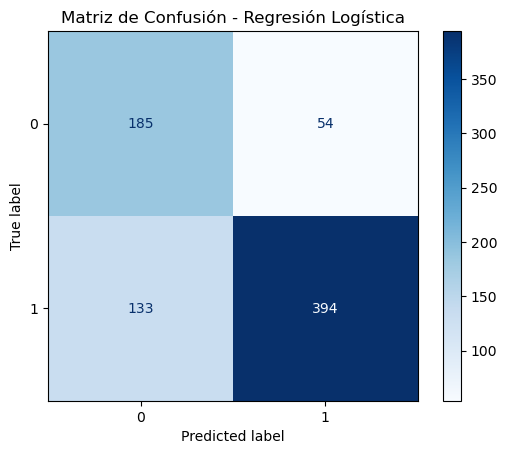

In [52]:
# Entrenar Regresión Logística
logistic_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
logistic_model.fit(X_train_lda, y_train)

# Predicciones
y_pred_logistic = logistic_model.predict(X_test_lda)

# Evaluación del Modelo
print("Reporte de Clasificación - Regresión Logística:")
print(classification_report(y_test, y_pred_logistic))

# Matriz de Confusión
ConfusionMatrixDisplay.from_estimator(logistic_model, X_test_lda, y_test, cmap='Blues')
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()


In [54]:
# Crear el modelo básico
logistic_model = LogisticRegression()

# Mostrar los parámetros predeterminados
print(logistic_model.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


## **Regresión Logística con Grid Search**

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores hiperparámetros encontrados:
{'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}
Reporte de Clasificación - Regresión Logística (Optimizada):
              precision    recall  f1-score   support

           0       0.58      0.78      0.66       239
           1       0.88      0.74      0.80       527

    accuracy                           0.75       766
   macro avg       0.73      0.76      0.73       766
weighted avg       0.79      0.75      0.76       766



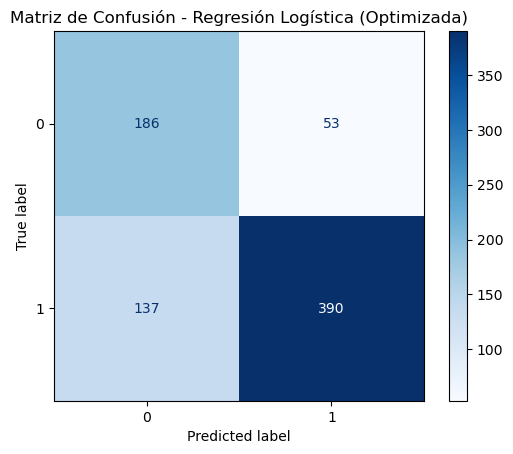

In [42]:
# Definir el espacio de hiperparámetros
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Inicializar el modelo base
logistic_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# Configurar Grid Search
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Ejecutar Grid Search
grid_search.fit(X_train_lda, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evaluar el modelo optimizado
best_logistic_model = grid_search.best_estimator_
y_pred_best_logistic = best_logistic_model.predict(X_test_lda)

# Reporte de clasificación
print("Reporte de Clasificación - Regresión Logística (Optimizada):")
print(classification_report(y_test, y_pred_best_logistic))

# Matriz de Confusión
ConfusionMatrixDisplay.from_estimator(best_logistic_model, X_test_lda, y_test, cmap='Blues')
plt.title("Matriz de Confusión - Regresión Logística (Optimizada)")
plt.show()

## **Regresión Logística con Random Search**

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores hiperparámetros encontrados con Random Search:
{'solver': 'saga', 'penalty': 'l1', 'C': 0.0030538555088334154}
Reporte de Clasificación - Regresión Logística (Random Search):
              precision    recall  f1-score   support

           0       0.58      0.78      0.66       239
           1       0.88      0.74      0.80       527

    accuracy                           0.75       766
   macro avg       0.73      0.76      0.73       766
weighted avg       0.79      0.75      0.76       766



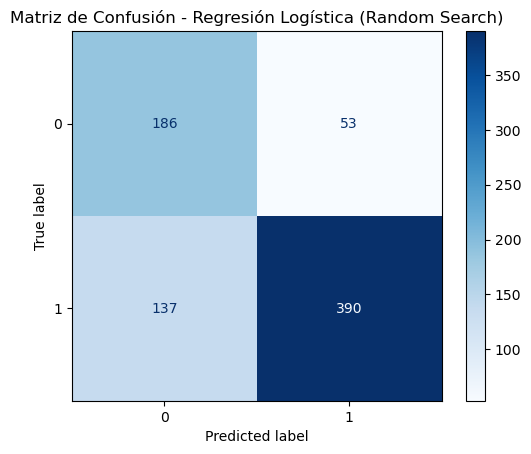

In [45]:
# Espacio de hiperparámetros para Random Search
param_distributions = {
    'C': np.logspace(-3, 3, 100),  # Valores entre 0.001 y 100
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Configurar Random Search
random_search = RandomizedSearchCV(
    estimator=logistic_model,
    param_distributions=param_distributions,
    n_iter=50,  # Número de combinaciones aleatorias a probar
    cv=5,
    scoring='f1',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Ejecutar Random Search
random_search.fit(X_train_lda, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados con Random Search:")
print(random_search.best_params_)

# Evaluar el modelo optimizado
best_logistic_random = random_search.best_estimator_
y_pred_random = best_logistic_random.predict(X_test_lda)

print("Reporte de Clasificación - Regresión Logística (Random Search):")
print(classification_report(y_test, y_pred_random))

ConfusionMatrixDisplay.from_estimator(best_logistic_random, X_test_lda, y_test, cmap='Blues')
plt.title("Matriz de Confusión - Regresión Logística (Random Search)")
plt.show()

## **Regresión Logística con Bayes Search**

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

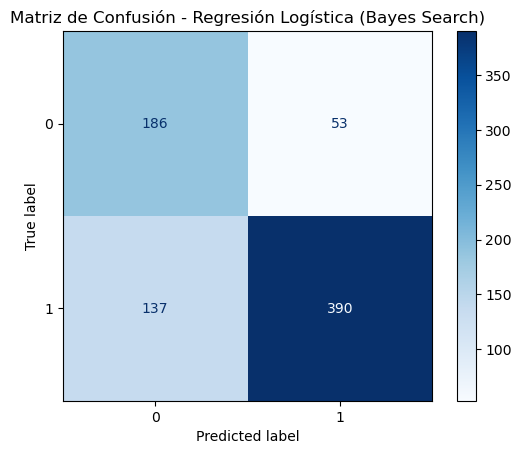

In [51]:
# Espacio de hiperparámetros para Bayes Search
bayes_param_space = {
    'C': (0.001, 100.0, 'log-uniform'),  # Escala logarítmica entre 0.001 y 100
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Configurar Bayes Search
bayes_search = BayesSearchCV(
    estimator=logistic_model,
    search_spaces=bayes_param_space,
    n_iter=50,  # Número de iteraciones
    cv=5,
    scoring='f1',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Ejecutar Bayes Search
bayes_search.fit(X_train_lda, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados con Bayes Search:")
print(bayes_search.best_params_)

# Evaluar el modelo optimizado
best_logistic_bayes = bayes_search.best_estimator_
y_pred_bayes = best_logistic_bayes.predict(X_test_lda)

print("Reporte de Clasificación - Regresión Logística (Bayes Search):")
print(classification_report(y_test, y_pred_bayes))

ConfusionMatrixDisplay.from_estimator(best_logistic_bayes, X_test_lda, y_test, cmap='Blues')
plt.title("Matriz de Confusión - Regresión Logística (Bayes Search)")
plt.show()

### Comparación de Resultados de Optimización

Se comparan los resultados del modelo básico y los métodos de optimización aplicados a la Regresión Logística. Aquí se evalúan los hiperparámetros encontrados y las métricas obtenidas.

| **Método**        | **Hiperparámetros**                                    | **Accuracy** | **F1-Score Clase 0** | **F1-Score Clase 1** | **Weighted Avg F1** |
|--------------------|-------------------------------------------------------|--------------|-----------------------|-----------------------|---------------------|
| **Modelo Básico**  | `{'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}`      | 76%          | 66%                  | 81%                  | 76%                |
| **Grid Search**    | `{'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}`     | 75%          | 66%                  | 80%                  | 76%                |
| **Random Search**  | `{'C': 0.003, 'penalty': 'l1', 'solver': 'saga'}`     | 75%          | 66%                  | 80%                  | 76%                |
| **Bayes Search**   | `{'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}`     | 75%          | 66%                  | 80%                  | 76%                |

#### Cambios en los Hiperparámetros
1. **`C` (Regularización):**
   - Modelo Básico: `C = 1.0` (regularización moderada).
   - Métodos Optimizados: `C` reducido (`0.001` o `0.003`), aplicando regularización más fuerte para evitar overfitting.

2. **`penalty` (Tipo de regularización):**
   - Modelo Básico y Grid/Bayes Search: `l2` (Ridge), que reduce el impacto de variables irrelevantes sin eliminarlas.
   - Random Search: `l1` (Lasso), que selecciona características relevantes eliminando las menos importantes.

3. **`solver` (Método de optimización):**
   - Modelo Básico: `lbfgs`, eficiente para regularización `l2` en problemas pequeños o medianos.
   - Métodos Optimizados: `saga`, adecuado para regularización `l1` o `l2` y escalable para datasets más grandes.

Estos cambios buscan un mejor balance entre precisión y generalización. Sin embargo, el rendimiento del modelo no varió significativamente con respecto al básico.


---

# 3. **Árbol de Decisión**

## **Árbol de Decisión sin optimización**

Reporte de Clasificación - Árbol de Decisión:
              precision    recall  f1-score   support

           0       0.52      0.51      0.51       239
           1       0.78      0.78      0.78       527

    accuracy                           0.70       766
   macro avg       0.65      0.65      0.65       766
weighted avg       0.70      0.70      0.70       766



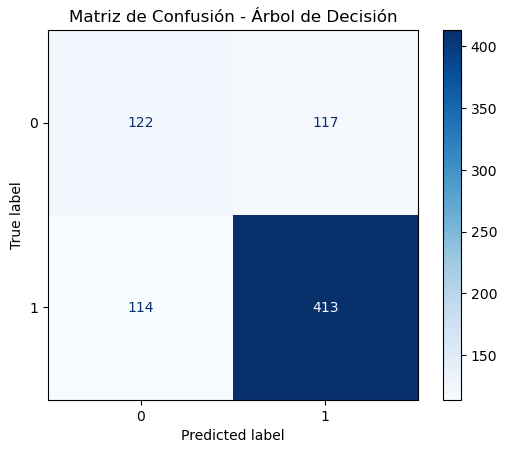

In [59]:
# Entrenar Árbol de Decisió
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_lda, y_train)

# Predicciones
y_pred_tree = tree_model.predict(X_test_lda)

# Evaluación del Modelo
print("Reporte de Clasificación - Árbol de Decisión:")
print(classification_report(y_test, y_pred_tree))

# Matriz de Confusión
ConfusionMatrixDisplay.from_estimator(tree_model, X_test_lda, y_test, cmap='Blues')
plt.title("Matriz de Confusión - Árbol de Decisión")
plt.show()

In [69]:
# Mostrar los parámetros predeterminados del Árbol de Decisión
print(tree_model.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


## **Árbol de Decisión con Grid search**

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Mejores hiperparámetros encontrados con Grid Search:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Reporte de Clasificación - Árbol de Decisión (Grid Search):
              precision    recall  f1-score   support

           0       0.62      0.62      0.62       239
           1       0.83      0.83      0.83       527

    accuracy                           0.76       766
   macro avg       0.72      0.72      0.72       766
weighted avg       0.76      0.76      0.76       766



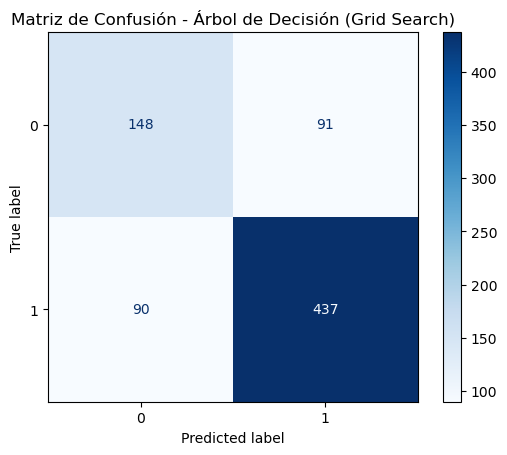

In [55]:
# Espacio de búsqueda
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Configurar Grid Search
tree_model = DecisionTreeClassifier(random_state=42)
grid_search_tree = GridSearchCV(
    estimator=tree_model,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Ejecutar Grid Search
grid_search_tree.fit(X_train_lda, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados con Grid Search:")
print(grid_search_tree.best_params_)

# Evaluar el modelo optimizado
best_tree_grid = grid_search_tree.best_estimator_
y_pred_tree_grid = best_tree_grid.predict(X_test_lda)

print("Reporte de Clasificación - Árbol de Decisión (Grid Search):")
print(classification_report(y_test, y_pred_tree_grid))

ConfusionMatrixDisplay.from_estimator(best_tree_grid, X_test_lda, y_test, cmap='Blues')
plt.title("Matriz de Confusión - Árbol de Decisión (Grid Search)")
plt.show()

## **Árbol de Decisión con Random search**

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores hiperparámetros encontrados con Random Search:
{'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 5, 'criterion': 'entropy'}
Reporte de Clasificación - Árbol de Decisión (Random Search):
              precision    recall  f1-score   support

           0       0.62      0.62      0.62       239
           1       0.83      0.83      0.83       527

    accuracy                           0.76       766
   macro avg       0.72      0.72      0.72       766
weighted avg       0.76      0.76      0.76       766



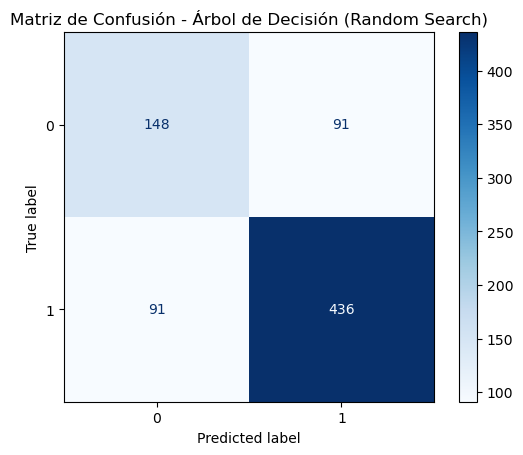

In [56]:
# Espacio de búsqueda
param_distributions = {
    'max_depth': [None] + list(np.arange(5, 21)),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 5),
    'criterion': ['gini', 'entropy']
}

# Configurar Random Search
random_search_tree = RandomizedSearchCV(
    estimator=tree_model,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='f1',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Ejecutar Random Search
random_search_tree.fit(X_train_lda, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados con Random Search:")
print(random_search_tree.best_params_)

# Evaluar el modelo optimizado
best_tree_random = random_search_tree.best_estimator_
y_pred_tree_random = best_tree_random.predict(X_test_lda)

print("Reporte de Clasificación - Árbol de Decisión (Random Search):")
print(classification_report(y_test, y_pred_tree_random))

ConfusionMatrixDisplay.from_estimator(best_tree_random, X_test_lda, y_test, cmap='Blues')
plt.title("Matriz de Confusión - Árbol de Decisión (Random Search)")
plt.show()

## **Árbol de Decisión con Bayes search**

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/opt/conda/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 5, 1, 10] before, using random point ['entropy', 13, 3, 8]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/conda/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 5, 1, 10] before, using random point ['entropy', 8, 3, 7]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/conda/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 5, 1, 10] before, using random point ['gini', 7, 4, 8]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/conda/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 5, 1, 10] before, using random point ['gini', 14, 4, 9]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

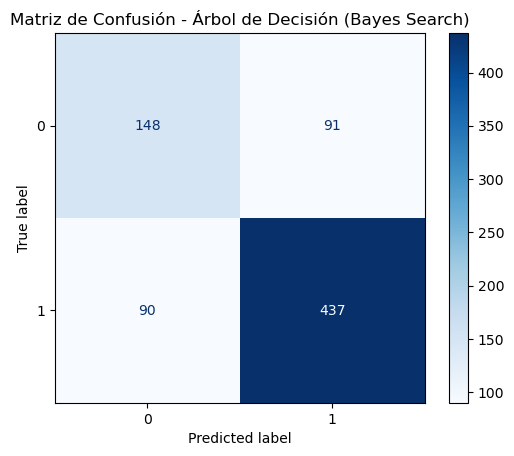

In [57]:
# Espacio de búsqueda
bayes_param_space = {
    'max_depth': (5, 20),  # Rango entre 5 y 20
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'criterion': ['gini', 'entropy']
}

# Configurar Bayes Search
bayes_search_tree = BayesSearchCV(
    estimator=tree_model,
    search_spaces=bayes_param_space,
    n_iter=50,
    cv=5,
    scoring='f1',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Ejecutar Bayes Search
bayes_search_tree.fit(X_train_lda, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados con Bayes Search:")
print(bayes_search_tree.best_params_)

# Evaluar el modelo optimizado
best_tree_bayes = bayes_search_tree.best_estimator_
y_pred_tree_bayes = best_tree_bayes.predict(X_test_lda)

print("Reporte de Clasificación - Árbol de Decisión (Bayes Search):")
print(classification_report(y_test, y_pred_tree_bayes))

ConfusionMatrixDisplay.from_estimator(best_tree_bayes, X_test_lda, y_test, cmap='Blues')
plt.title("Matriz de Confusión - Árbol de Decisión (Bayes Search)")
plt.show()

# Comparación de Resultados para Árbol de Decisión

Se analizan el modelo básico y las optimizaciones realizadas con Grid Search, Random Search y Bayes Search.

| **Método**        | **Hiperparámetros**                                                    | **Accuracy** | **F1-Score Clase 0** | **F1-Score Clase 1** | **Weighted Avg F1** |
|--------------------|-----------------------------------------------------------------------|--------------|-----------------------|-----------------------|---------------------|
| **Modelo Básico**  | `{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}` | 70%          | 51%                  | 78%                  | 70%                |
| **Grid Search**    | `{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}` | 76%          | 62%                  | 83%                  | 76%                |
| **Random Search**  | `{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 6}` | 76%          | 62%                  | 83%                  | 76%                |
| **Bayes Search**   | `{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}` | 76%          | 62%                  | 83%                  | 76%                |

## Cambios en los Hiperparámetros
1. **`criterion`**:
   - Básico: `'gini'` (impureza de Gini).
   - Optimizados: `'entropy'`, que utiliza la ganancia de información para medir la calidad de las divisiones.

2. **`max_depth`**:
   - Básico: Sin límite (`None`), permitiendo que el árbol crezca hasta que todas las hojas sean puras o haya menos de `min_samples_split` en un nodo.
   - Optimizados: Limitado a `5`, lo que simplifica el árbol y ayuda a prevenir el overfitting.

3. **`min_samples_split`**:
   - Básico: `2` (nodos se dividen con al menos 2 muestras).
   - Optimizados: Incrementado a `6` en Random Search, lo que genera divisiones más robustas.

4. **`min_samples_leaf`**:
   - Básico: `1` (hojas con al menos una muestra).
   - Optimizados: Incrementado a `2` en Random Search, lo que reduce la probabilidad de hojas aisladas.

## Observaciones
1. **Rendimiento**:
   - Las optimizaciones con **Grid Search**, **Random Search** y **Bayes Search** mejoraron el rendimiento en todas las métricas.
   - Accuracy y F1-Score global aumentaron de **70% a 76%**.
   - El modelo optimizado tiene un mejor balance entre las clases, con un **F1-Score de 62% para la Clase 0** y **83% para la Clase 1**.

2. **Tiempo de Ejecución**:
   - **Grid Search** probó 90 combinaciones y tomó más tiempo (~450 fits).
   - **Random Search** probó menos combinaciones (~250 fits) y fue más eficiente.
   - **Bayes Search** también probó menos combinaciones (~250 fits) pero fue más lento debido a los cálculos adicionales en cada iteración.

3. **Hiperparámetros Finales**:
   - **Grid Search** y **Bayes Search** encontraron configuraciones idénticas, indicando que limitar la profundidad del árbol y usar `'entropy'` mejora el rendimiento.

## Conclusión
El modelo básico fue mejorado significativamente mediante la optimización. **Random Search** logró resultados equivalentes en menos tiempo, mientras que **Bayes Search**, aunque efectivo, fue el más lento en este caso.


---

## **KNN sin optimización**

Reporte de Clasificación - KNN:
              precision    recall  f1-score   support

           0       0.59      0.51      0.55       239
           1       0.79      0.84      0.82       527

    accuracy                           0.74       766
   macro avg       0.69      0.68      0.68       766
weighted avg       0.73      0.74      0.73       766



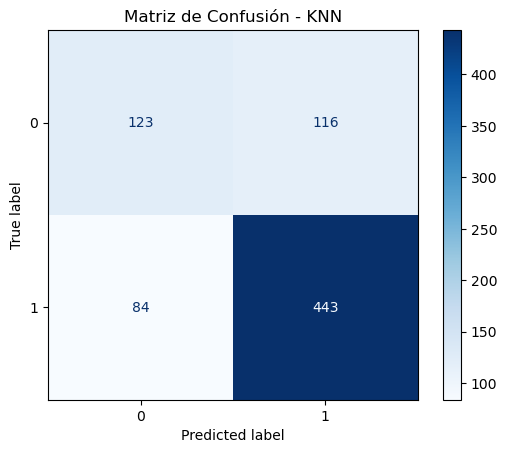

In [71]:
# Entrenar KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_lda, y_train)

# Predicciones
y_pred_knn = knn_model.predict(X_test_lda)

# Evaluación del Modelo
print("Reporte de Clasificación - KNN:")
print(classification_report(y_test, y_pred_knn))

# Matriz de Confusión
ConfusionMatrixDisplay.from_estimator(knn_model, X_test_lda, y_test, cmap='Blues')
plt.title("Matriz de Confusión - KNN")
plt.show()

In [70]:
# Mostrar los parámetros predeterminados de KNN
print(knn_model.get_params())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


## **KNN con Grid search**

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros encontrados con Grid Search:
{'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'uniform'}
Reporte de Clasificación - KNN (Grid Search):
              precision    recall  f1-score   support

           0       0.65      0.53      0.58       239
           1       0.80      0.87      0.84       527

    accuracy                           0.76       766
   macro avg       0.73      0.70      0.71       766
weighted avg       0.75      0.76      0.76       766



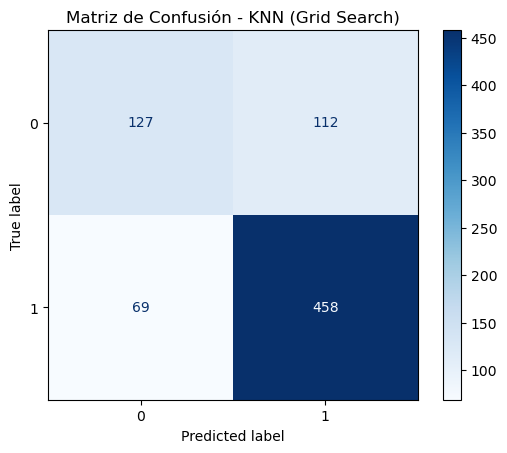

In [63]:
# Espacio de búsqueda
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Configurar Grid Search
knn_model = KNeighborsClassifier()
grid_search_knn = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Ejecutar Grid Search
grid_search_knn.fit(X_train_lda, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados con Grid Search:")
print(grid_search_knn.best_params_)

# Evaluar el modelo optimizado
best_knn_grid = grid_search_knn.best_estimator_
y_pred_knn_grid = best_knn_grid.predict(X_test_lda)

print("Reporte de Clasificación - KNN (Grid Search):")
print(classification_report(y_test, y_pred_knn_grid))

ConfusionMatrixDisplay.from_estimator(best_knn_grid, X_test_lda, y_test, cmap='Blues')
plt.title("Matriz de Confusión - KNN (Grid Search)")
plt.show()

## **KNN con Random search**

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores hiperparámetros encontrados con Random Search:
{'weights': 'uniform', 'n_neighbors': 13, 'metric': 'minkowski'}
Reporte de Clasificación - KNN (Random Search):
              precision    recall  f1-score   support

           0       0.65      0.53      0.58       239
           1       0.80      0.87      0.84       527

    accuracy                           0.76       766
   macro avg       0.73      0.70      0.71       766
weighted avg       0.75      0.76      0.76       766



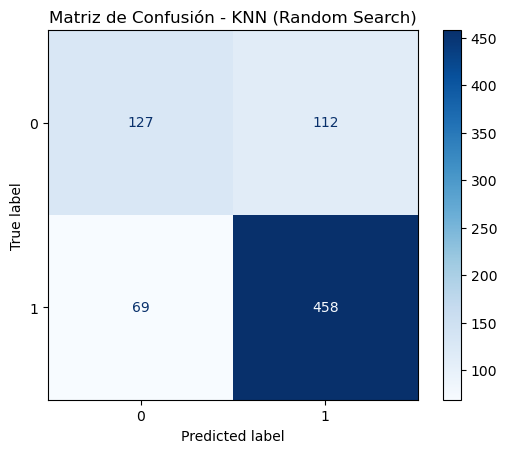

In [64]:
# Espacio de búsqueda
param_distributions = {
    'n_neighbors': np.arange(1, 16),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Configurar Random Search
random_search_knn = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='f1',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Ejecutar Random Search
random_search_knn.fit(X_train_lda, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados con Random Search:")
print(random_search_knn.best_params_)

# Evaluar el modelo optimizado
best_knn_random = random_search_knn.best_estimator_
y_pred_knn_random = best_knn_random.predict(X_test_lda)

print("Reporte de Clasificación - KNN (Random Search):")
print(classification_report(y_test, y_pred_knn_random))

ConfusionMatrixDisplay.from_estimator(best_knn_random, X_test_lda, y_test, cmap='Blues')
plt.title("Matriz de Confusión - KNN (Random Search)")
plt.show()


## **KNN con Bayes search**

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

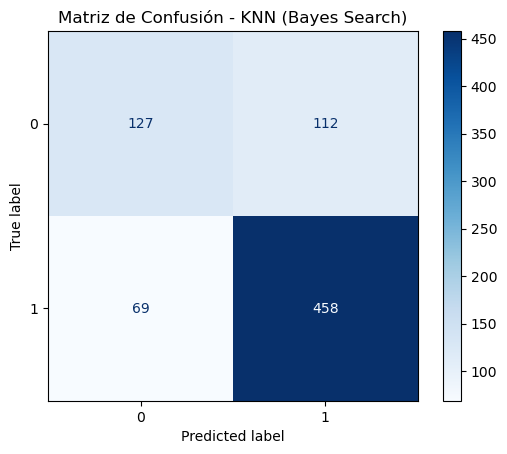

In [65]:
# Espacio de búsqueda
bayes_param_space = {
    'n_neighbors': (1, 15),  # Rango entre 1 y 15
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Configurar Bayes Search
bayes_search_knn = BayesSearchCV(
    estimator=knn_model,
    search_spaces=bayes_param_space,
    n_iter=50,
    cv=5,
    scoring='f1',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Ejecutar Bayes Search
bayes_search_knn.fit(X_train_lda, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados con Bayes Search:")
print(bayes_search_knn.best_params_)

# Evaluar el modelo optimizado
best_knn_bayes = bayes_search_knn.best_estimator_
y_pred_knn_bayes = best_knn_bayes.predict(X_test_lda)

print("Reporte de Clasificación - KNN (Bayes Search):")
print(classification_report(y_test, y_pred_knn_bayes))

ConfusionMatrixDisplay.from_estimator(best_knn_bayes, X_test_lda, y_test, cmap='Blues')
plt.title("Matriz de Confusión - KNN (Bayes Search)")
plt.show()


# Comparación de Resultados para KNN

Se analizan el modelo básico y las optimizaciones realizadas con Grid Search, Random Search y Bayes Search.

| **Método**        | **Hiperparámetros**                                       | **Accuracy** | **F1-Score Clase 0** | **F1-Score Clase 1** | **Weighted Avg F1** |
|--------------------|----------------------------------------------------------|--------------|-----------------------|-----------------------|---------------------|
| **Modelo Básico**  | `{'n_neighbors': 5, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'auto', 'leaf_size': 30, 'p': 2}` | 74%          | 55%                  | 82%                  | 73%                |
| **Grid Search**    | `{'n_neighbors': 13, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'auto', 'leaf_size': 30, 'p': 2}` | 76%          | 58%                  | 84%                  | 76%                |
| **Random Search**  | `{'n_neighbors': 13, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'auto', 'leaf_size': 30, 'p': 2}` | 76%          | 58%                  | 84%                  | 76%                |
| **Bayes Search**   | `{'n_neighbors': 13, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'auto', 'leaf_size': 30, 'p': 2}` | 76%          | 58%                  | 84%                  | 76%                |

## Cambios en los Hiperparámetros
1. **`n_neighbors`**:
   - Básico: `5`.
   - Optimizados: Incrementado a `13`, lo que suaviza el modelo al considerar más vecinos.

2. **`weights`**:
   - Básico y Optimizados: `'uniform'` (todos los vecinos tienen el mismo peso).

3. **`metric`**:
   - Básico: `'minkowski'` (generalización de la distancia euclidiana, con `p=2` equivale a euclidiana).
   - Grid Search: `'euclidean'` (caso particular de Minkowski con `p=2`).
   - Random y Bayes Search: Retienen `'minkowski'`.

4. **Otros parámetros (no cambiados)**:
   - `'algorithm': 'auto'`: Selección automática del mejor algoritmo de búsqueda.
   - `'leaf_size': 30'`: No fue ajustado; controla el tamaño de las hojas en el árbol para búsquedas KD-Tree o Ball-Tree.
   - `'p': 2'`: Exponente en Minkowski, equivalente a distancia euclidiana cuando es `2`.

## Observaciones
1. **Rendimiento**:
   - Las optimizaciones con **Grid Search**, **Random Search** y **Bayes Search** mejoraron ligeramente el rendimiento del modelo básico.
   - Accuracy y F1-Score global aumentaron de **74% a 76%**.
   - F1-Score para la Clase 0 subió de **55% a 58%**, indicando mejor identificación de la clase minoritaria.

2. **Tiempo de Ejecución**:
   - **Grid Search** probó 48 combinaciones (~240 fits).
   - **Random Search** probó 50 combinaciones (~250 fits).
   - **Bayes Search** realizó ~50 fits, pero con cálculos más complejos, siendo más lento que Random Search.

3. **Hiperparámetros Finales**:
   - Random Search y Bayes Search encontraron configuraciones idénticas (`13` vecinos, `'minkowski'`), mientras que Grid Search seleccionó `'euclidean'` como métrica.

## Conclusión
El modelo básico fue ligeramente mejorado con la optimización. **Grid Search**, **Random Search** y **Bayes Search** lograron resultados muy similares, pero **Random Search** y **Bayes Search** fueron más eficientes en encontrar configuraciones equivalentes.


## Resumen de Resultados

| **Modelo**          | **Método Básico (Accuracy)** | **Optimizado (Accuracy)** | **Mejora Global** | **Observaciones** |
|----------------------|-----------------------------|---------------------------|-------------------|-------------------|
| **Regresión Logística** | 76%                        | 75%                        | Sin mejora         | Ya estaba cerca de óptimo. |
| **Árbol de Decisión**   | 70%                        | 76%                        | +6%                | La optimización simplificó el modelo, mejorando generalización. |
| **KNN**                | 74%                        | 76%                        | +2%                | El ajuste fino de `n_neighbors` mejoró el rendimiento. |

## Por qué la Optimización Funcionó Mejor o Peor

En **Regresión Logística**, la optimización no mejoró los resultados porque el modelo básico ya funcionaba bien. Sus parámetros predeterminados (`C=1.0`, `penalty='l2'`, `solver='lbfgs'`) eran adecuados, y ajustes como reducir `C` no aportaron mejoras. El modelo inicial ya estaba bien configurado y los datos no necesitan cambios grandes.

En **Árbol de Decisión**, la optimización mejoró el modelo. El modelo básico dejaba que el árbol creciera demasiado (`max_depth=None`), causando overfitting. Limitar la profundidad (`max_depth=5`) y usar `'entropy'` en lugar de `'gini'` ayudó a generalizar mejor. Ajustar parámetros como `min_samples_split` y `min_samples_leaf` evitó divisiones innecesarias y nodos muy pequeños.

En **KNN**, la optimización mejoró ligeramente. El modelo básico (`n_neighbors=5`) era demasiado sensible a los valores locales. Aumentar los vecinos a `n_neighbors=13` suavizó las predicciones, mejorando el equilibrio entre precisión y generalización. Cambiar la métrica de distancia tuvo poco impacto porque `'minkowski'` con `p=2` es igual a `'euclidean'`. Ajustar `n_neighbors` fue lo más útil.

En general, la optimización funcionó mejor en modelos complejos como Árbol de Decisión, donde simplificar el modelo evitó overfitting. En Regresión Logística, el impacto fue mínimo porque ya estaba cerca del óptimo, en el KNN, pequeños ajustes lograron una mejora moderada. 



## Feedback Personal

La asignatura me ha gustado mucho, y creo que es de las más interesantes porque se centra en aplicar algoritmos y trabajar con machine learning, que es lo que más nos llama la atención. Mola ver cómo lo que aprendemos se aplica a problemas reales.

Si empiezo por lo "malo", que no es malo, lo que menos me gustó, diría que fue la primera parte de la asignatura. Es más teórica y, aunque necesaria para entender lo que viene después, no es tan práctica ni tan entretenida como los algoritmos avanzados. Quizás podría ser un poco más práctica para que sea más llevadera, pero entiendo que es una base importante y se agradece mucho que no hubiera entregables en esta parte, porque estábamos bastante cargados con otras asignaturas.

Lo que más me ha gustado han sido las 4 prácticas. Son muy entretenidas, están bien explicadas y los ejemplos son claros y útiles. Te animan a probar cosas nuevas, buscar mejores resultados y entender mejor los algoritmos. Además, aplicar lo aprendido en las prácticas hace que las clases sean más interesantes y que quieras aprender más.

En general, la asignatura está muy bien organizada. Muchas gracias por el esfuerzo, experiencia muy buena.
